In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lifetimes.utils import summary_data_from_transaction_data
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

import datetime


%matplotlib inline

# Importing customer data

In [2]:
DF = pd.read_csv("Datasets/DF.csv",  usecols=['AccessTime', 'PeopleId'], parse_dates=['AccessTime']).dropna()

DF.PeopleId = DF.PeopleId.astype(int)

DF.head()

,AccessTime,PeopleId
0,2015-06-22 12:48:49,24055
1,2015-06-22 12:49:03,1435
2,2015-06-22 12:49:16,12752
3,2015-06-22 12:49:31,14684
4,2015-06-22 12:50:08,24513


# Deciding Analysis Range

In [3]:
#start_date = datetime.datetime(2014, 1, 1)
#end_date = datetime.datetime(2017, 6, 30)
#DF = DF[(DF.AccessTime >= start_date) & (DF.AccessTime <= end_date)]

In [4]:
print DF.AccessTime.min()
print DF.AccessTime.max()

2009-03-07 13:22:14
2017-08-14 17:57:27


# Transforming my data
Most often, the dataset you have at hand will be at the transaction level. Lifetimes has some utility functions to transform that transactional data (one row per purchase) into summary data (a frequency, recency and age dataset).

In [5]:
summary = summary_data_from_transaction_data(DF, 'PeopleId', 'AccessTime')
summary.head()

,frequency,recency,T
PeopleId,,,
0,86.0,2739.0,2741.0
1,3.0,1847.0,2262.0
2,2.0,785.0,887.0
3,4.0,1444.0,1545.0
4,4.0,2387.0,2553.0




For all models, the following nomenclature is used:

frequency represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases. This is actually slightly wrong. It’s the count of time periods the customer had a purchase in. So if using days as units, then it’s the count of days the customer had a purchase on.
T represents the age of the customer in whatever time units chosen (daily, in the above dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.
recency represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)
If your data is not in the format (very common), there are utility functions in lifetimes to transform your data to look like this

# Basic Frequency/Recency analysis using the BG/NBD model
We’ll use the BG/NBD model first. There are other models which we will explore in these docs, but this is the simplest to start with.

In [6]:
bgf = BetaGeoFitter(penalizer_coef=0.1) #In typical applications, penalizers on the order of 0.001 to 0.1 are effective.
bgf.fit(summary['frequency'], summary['recency'], summary['T']) 
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 18298 subjects, a: 0.19, alpha: 14.45, b: 0.88, r: 0.77>


After fitting, we have lots of nice methods and properties attached to the fitter object.

For small samples sizes, the parameters can get implausibly large, so by adding an l2 penalty the likelihood, we can control how large these parameters can be. This is implemented as setting as positive penalizer_coef in the initialization of the model. In typical applications, penalizers on the order of 0.001 to 0.1 are effective.

# Visualizing our Frequency/Recency Matrix
Consider: a customer bought from you every day for three weeks straight, and we haven’t heard from them in months. What are the chances they are still “alive”? Pretty small. On the other hand, a customer who historically buys from you once a quarter, and bought last quarter, is likely still alive. We can visualize this relationship using the Frequency/Recency matrix, which computes the expected number of transactions a artificial customer is to make in the next time period, given his or her recency (age at last purchase) and frequency (the number of repeat transactions he or she has made).

/Users/stefano/anaconda/lib/python2.7/site-packages/lifetimes/fitters/beta_geo_fitter.py:195: RuntimeWarning: overflow encountered in double_scalars
  ((alpha + T) / (alpha + recency)) ** (r + x)


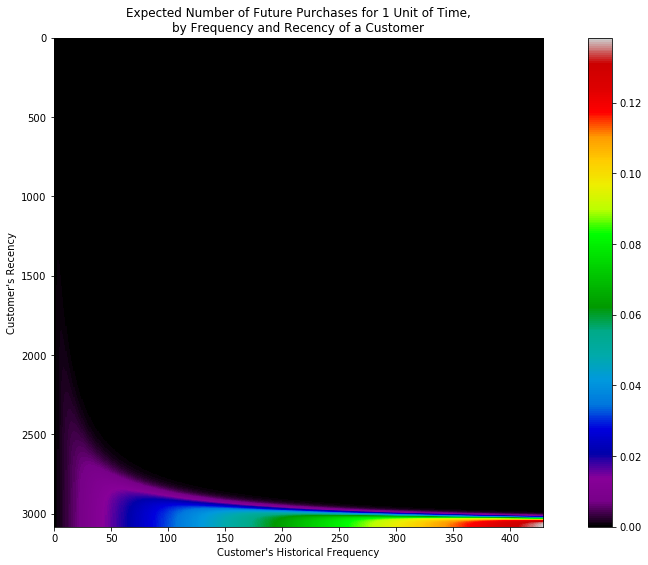

In [7]:
fig, ax = plt.subplots(figsize=(16,9))
plot_frequency_recency_matrix(bgf, cmap='nipy_spectral')

We can see that if a customer has bought 25 times from you, and their latest purchase was when they were 35 weeks old (given the individual is 35 weeks old), then they are your best customer (bottom-right). Your coldest customers are those that are in the top-right corner: they bought a lot quickly, and we haven’t seen them in weeks.

There’s also that beautiful “tail” around (5,25). That represents the customer who buys infrequently, but we’ve seen him or her recently, so they might buy again - we’re not sure if they are dead or just between purchases.

# Another interesting matrix to look at is the probability of still being alive:

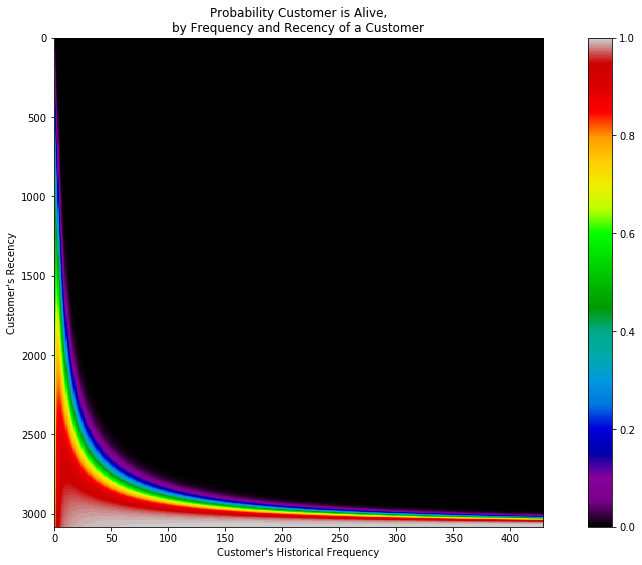

In [8]:
fig, ax = plt.subplots(figsize=(16,9))
plot_probability_alive_matrix(bgf, cmap='nipy_spectral')

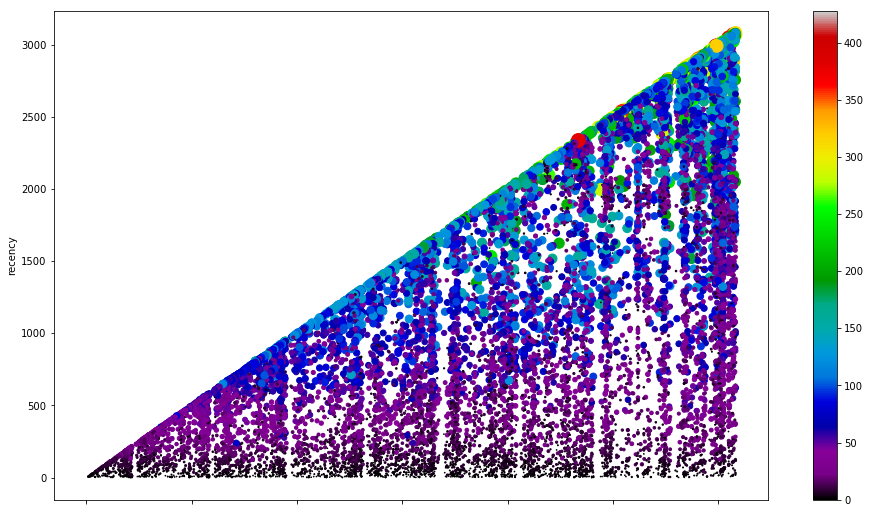

In [9]:
#plt.scatter(summary.T, summary.recency)
summary.plot.scatter('T', 'recency', figsize=(16,9), s=0.5*summary.frequency, c=summary.frequency, cmap='nipy_spectral')


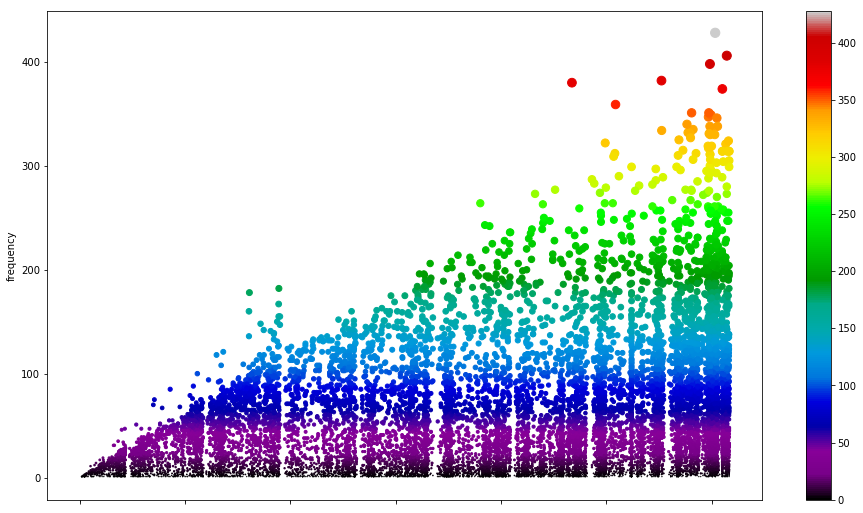

In [10]:

summary.plot.scatter('T', 'frequency', figsize=(16,9), s=0.2*summary.frequency, c=summary.frequency, cmap='nipy_spectral')

# Ranking customers from best to worst
Let’s return to our customers and rank them from “highest expected purchases in the next period” to lowest. Models expose a method that will predict a customer’s expected purchases in the next period using their history.

In [11]:
t = 365
summary['predicted_entries'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, summary['frequency'], summary['recency'], summary['T'])

##
#summary['predicted_purchasesNEW'] = bgf.probability_of_n_purchases_up_to_time(t, summary['frequency'], summary['recency'], summary['T'])
##

#Top 10 customer next calendar year
summary.sort_values(by=['predicted_entries'], ascending=False).head(10)

,frequency,recency,T,predicted_entries
PeopleId,,,,
805,178.0,805.0,805.0,76.663274
2850,46.0,196.0,199.0,71.122535
13781,75.0,350.0,354.0,69.423400
808,160.0,803.0,803.0,69.098038
41506,47.0,210.0,214.0,68.134141
12,182.0,941.0,945.0,67.186691
39742,85.0,427.0,429.0,66.115947
31835,118.0,649.0,649.0,62.404442
42,167.0,940.0,944.0,61.731110


In [12]:
# Historical best customer
summary.loc[[4491, 14812, 975, 355, 3089, 4285, 1320, 12740, 1238, 1131]]

,frequency,recency,T,predicted_entries
PeopleId,,,,
4491,324.0,3073.0,3079.0,37.868933
14812,380.0,2336.0,2336.0,58.280447
975,335.0,2907.0,2911.0,41.383849
355,349.0,2991.0,2996.0,41.901937
3089,359.0,2538.0,2543.0,50.634964
4285,374.0,3047.0,3050.0,44.124617
1320,340.0,2857.0,2882.0,42.005944
12740,216.0,2443.0,2490.0,29.604863
1238,332.0,2813.0,2887.0,10.134707


## Greg code on timedate to make it more readable

In [13]:
########################################################################
how_long_ago = summary['T'].map(lambda x: datetime.timedelta(days=x))
today_many_times = ([datetime.datetime(2017,8,14)]*len(summary.index))
age_frame = pd.Series(index=summary.index.astype(int), data=today_many_times)
when_we_first_saw_them = pd.to_datetime(age_frame - how_long_ago)
########################################################################

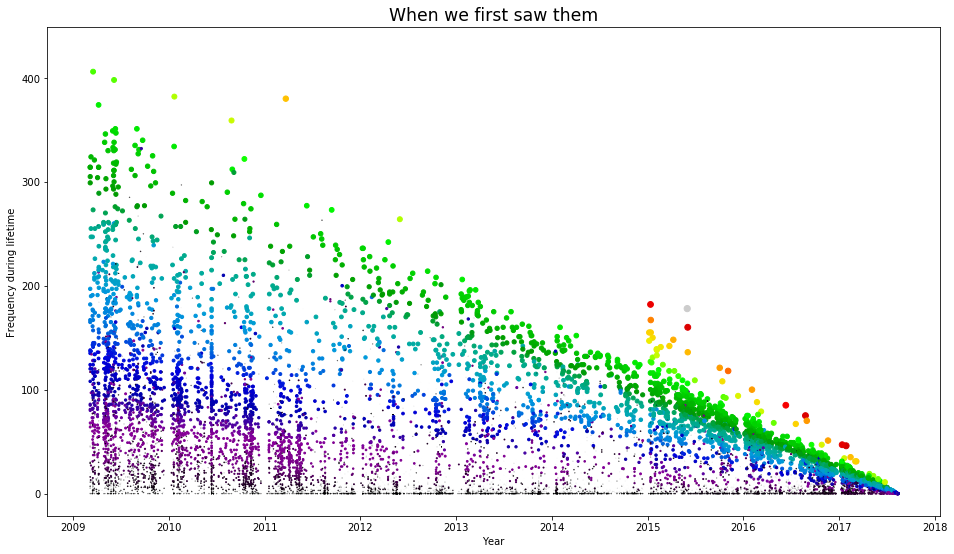

In [14]:
plt.figure(figsize=(16,9))

plt.xlabel('Year')
plt.ylabel('Frequency during lifetime')
plt.title('When we first saw them', size='xx-large')

plt.scatter(list(when_we_first_saw_them.dt.date), 
            summary.frequency, 
            s=summary.predicted_entries*0.5,  
            c=summary.predicted_entries, 
            cmap='nipy_spectral') 


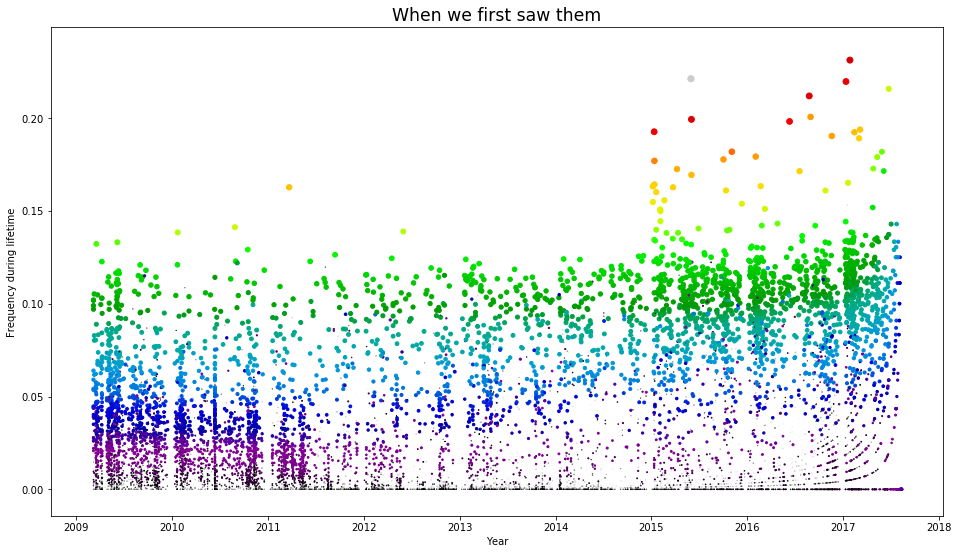

In [15]:
plt.figure(figsize=(16,9))

plt.xlabel('Year')
plt.ylabel('Frequency during lifetime')
plt.title('When we first saw them', size='xx-large')

plt.scatter(list(when_we_first_saw_them.dt.date), 
            summary.frequency/summary['T'], 
            s=summary.predicted_entries*0.5,  
            c=summary.predicted_entries, 
            cmap='nipy_spectral') 

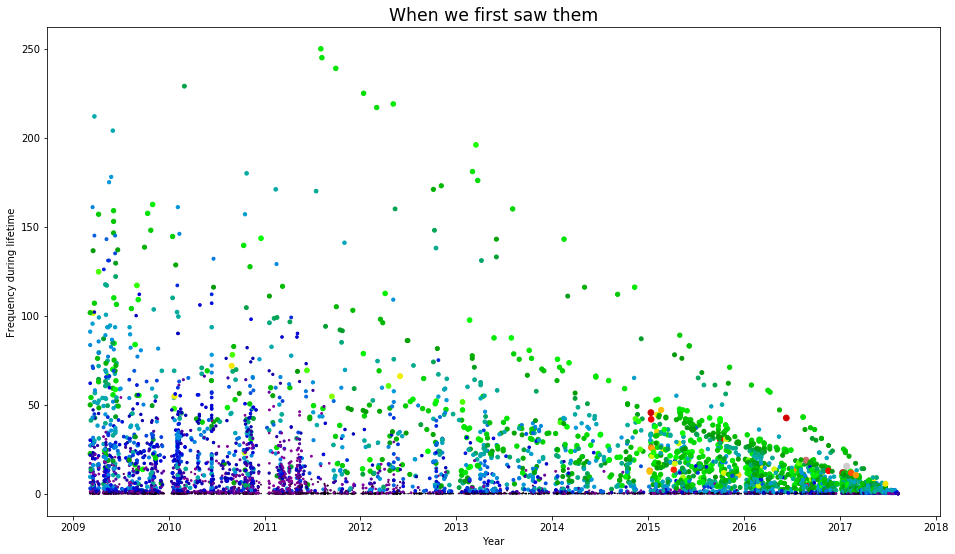

In [16]:
# Still not fixed.........

plt.figure(figsize=(16,9))

plt.xlabel('Year')
plt.ylabel('Frequency during lifetime')
plt.title('When we first saw them', size='xx-large')
#plt.legend(list(summary.predicted_purchases))
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.scatter(list(when_we_first_saw_them.dt.date),
            summary.frequency/(summary['T'] - summary['recency']),
            s=summary.predicted_entries*0.5,  
            c=summary.predicted_entries, cmap='nipy_spectral'
           ) 

# Assessing model fit
Ok, we can predict and we can visualize our customers’ behaviour, but is our model correct? There are a few ways to assess the model’s correctness. The first is to compare your data versus artificial data simulated with your fitted model’s parameters.

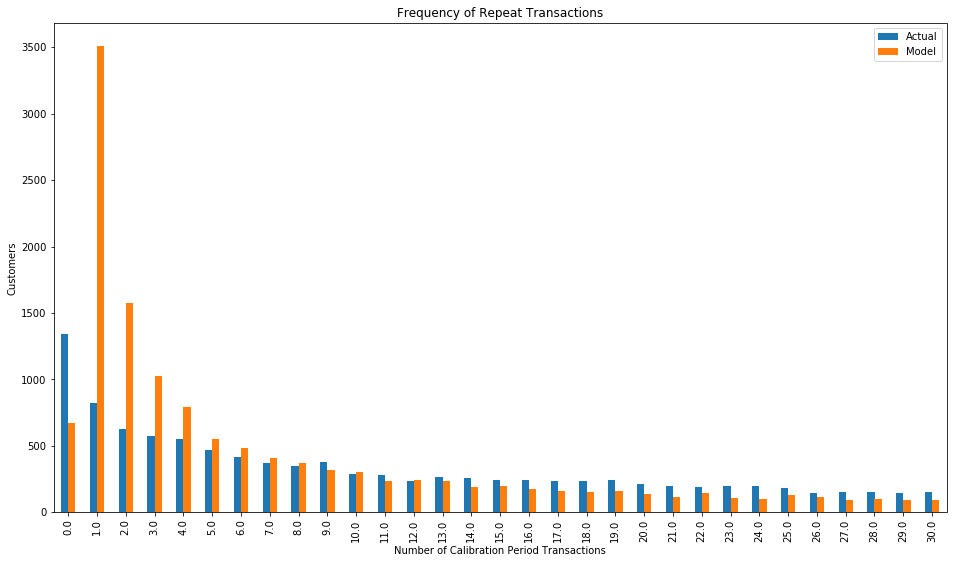

In [17]:
plot_period_transactions(bgf, figsize=(16,9), max_frequency=31)

We can see that our actual data and our simulated data line up well. This proves that our model doesn’t suck.

# More model fitting
With transactional data, we can partition the dataset into a calibration period dataset and a holdout dataset. This is important as we want to test how our model performs on data not yet seen (think cross-validation in standard machine learning literature). Lifetimes has a function to partition our dataset like this:

In [18]:
summary_cal_holdout = calibration_and_holdout_data(DF, 'PeopleId', 'AccessTime', 
                                                   calibration_period_end='2016-12-31',
                                                   observation_period_end='2017-06-30')   
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
PeopleId,,,,,
0,13.0,1796.0,2515.0,62.0,181
1,3.0,1847.0,2036.0,0.0,181
2,1.0,69.0,661.0,1.0,181
3,3.0,1205.0,1319.0,1.0,181
4,3.0,1853.0,2327.0,1.0,181


With this dataset, we can perform fitting on the _cal columns, and test on the _holdout columns:

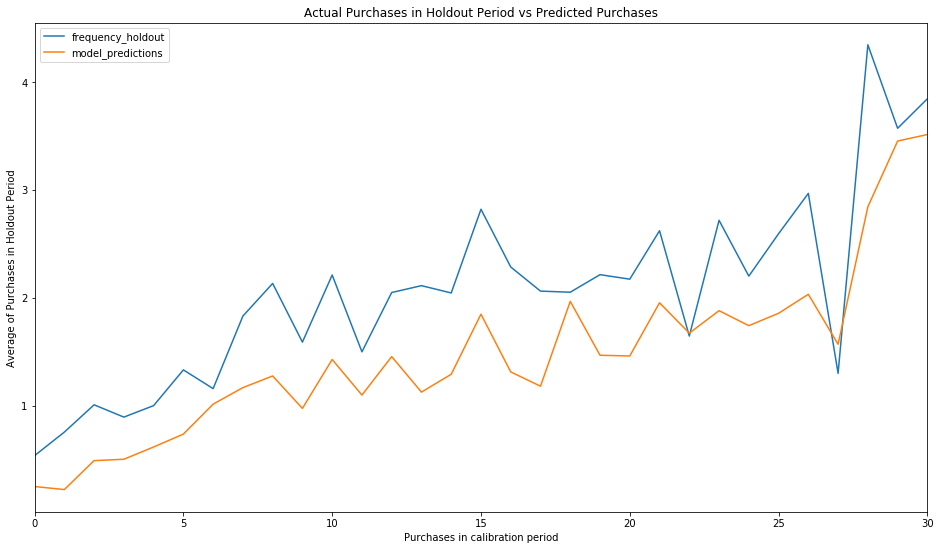

In [19]:
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])

plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout,  figsize=(16,9), n=31)

# Customer Predictions
Based on customer history, we can predict what an individuals future purchases might look like:

In [20]:
t = 365 #predict purchases in 10 periods
individual = summary.iloc[0]
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_to_time`
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])
# 0.0576511

11.334845547669081

# Customer Probability Histories
Given a customer transaction history, we can calculate their historical probability of being alive, according to our trained model. For example:

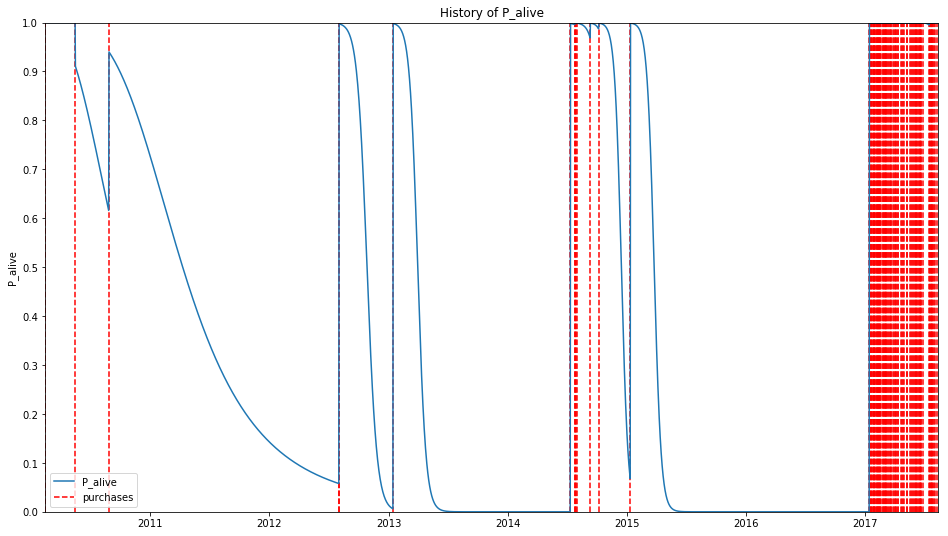

In [21]:
# do top 6 at the same time
from lifetimes.plotting import plot_history_alive

id = 0
days_since_birth = 365
sp_trans = DF.loc[DF['PeopleId'] == id]

fig, ax = plt.subplots(figsize=(16,9))
plot_history_alive(bgf, days_since_birth, sp_trans, 'AccessTime', freq='D')

In [22]:
STOP !!!

SyntaxError: invalid syntax (<ipython-input-22-dc8a7112d43f>, line 1)

# Estimating customer lifetime value using the Gamma-Gamma model
For this whole time we didn’t take into account the economic value of each transaction and we focused mainly on transactions’ occurrences. To estimate this we can use the Gamma-Gamma submodel. But first we need to create summary data from transactional data also containing economic values for each transaction (i.e. profits or revenues).

In [ ]:
from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value

summary['monetary_value'] = summary['frequency']
summary_with_money_value = summary

#print summary_with_money_value.head()

returning_customers_summary = summary_with_money_value[summary_with_money_value['frequency']>0]

returning_customers_summary.head()

# The Gamma-Gamma model and the independence assumption
The model we are going to use to estimate the CLV for our userbase is called the Gamma-Gamma submodel, which relies upon an important assumption. The Gamma-Gamma submodel, in fact, assumes that there is no relationship between the monetary value and the purchase frequency. In practice we need to check whether the Pearson correlation between the two vectors is close to 0 in order to use this model.


In [ ]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

# Customer Lifetime Value (CLV):
At this point we can train our Gamma-Gamma submodel and predict the conditional, expected average lifetime value of our customers.

In [ ]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

# Average transaction value:

In [ ]:
print(ggf.conditional_expected_average_profit(
        summary_with_money_value['frequency'],
        summary_with_money_value['monetary_value']
    ).head(10))

In [ ]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        summary_with_money_value['frequency'],
        summary_with_money_value['monetary_value']
    ).mean(),
    summary_with_money_value[summary_with_money_value['frequency']>0]['monetary_value'].mean()
))

# CLV using the DCF method
While for computing the total CLV using the DCF method (https://en.wikipedia.org/wiki/Discounted_cash_flow) adjusting for cost of capital:

In [ ]:
# refit the BG model to the summary_with_money_value dataset
bgf.fit(summary_with_money_value['frequency'], summary_with_money_value['recency'], summary_with_money_value['T'])

ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    summary_with_money_value['frequency'],
    summary_with_money_value['recency'],
    summary_with_money_value['T'],
    summary_with_money_value['monetary_value'],
    time=12, # months
    discount_rate=0.01).head(10) # monthly discount rate ~ 12.7% annually
